In [62]:
import os
import json
import pandas as pd
import seaborn as sns

from stress_slurm import config

In [63]:
RESULT_PATH = config.RESULTS_FOLDER_PATH + "/scenarios/"
SCENARIOS = ["1-LOSO_15real", "5-LOSO_15real_noised"] # ["1-LOSO_15real", "2-TSTR_15syn", "3-TSTR_cGAN", "4-LOSO_cGAN", "5-LOSO_cGAN"]

          model    eps        f1       std
0           CNN    0.1  0.881003  0.005690
1   Transformer    0.1  0.824875  0.025768
2      CNN-LSTM    0.1  0.859890  0.011964
3           CNN    1.0  0.879480  0.007136
4   Transformer    1.0  0.793712  0.022559
5      CNN-LSTM    1.0  0.861767  0.016237
6           CNN   10.0  0.875799  0.008668
7      CNN-LSTM   10.0  0.863139  0.016359
8   Transformer   10.0  0.812600  0.027640
9           CNN  100.0  0.877057  0.008523
10  Transformer  100.0  0.810849  0.021341
11     CNN-LSTM  100.0  0.864287  0.012821
    noise multiplier  stress f1       std
0                0.0   0.875746  0.006234
1                0.1   0.875618  0.008733
2                0.2   0.878336  0.004718
3                0.3   0.877083  0.008673
4                0.4   0.874079  0.007642
5                0.5   0.864407  0.007924
6                0.6   0.852595  0.008670
7                0.7   0.829561  0.008552
8                0.8   0.801396  0.008260
9                0.9 

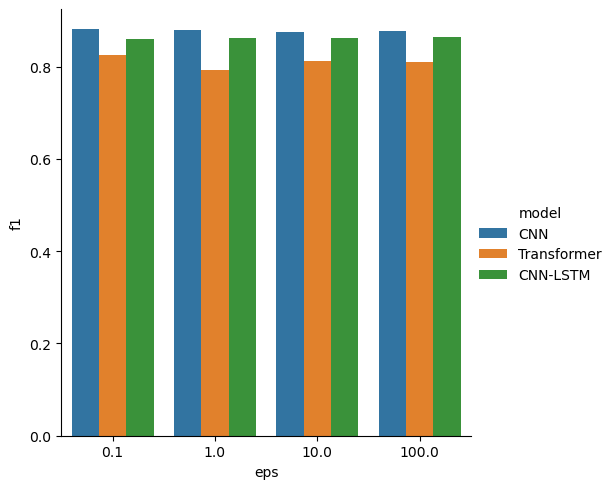

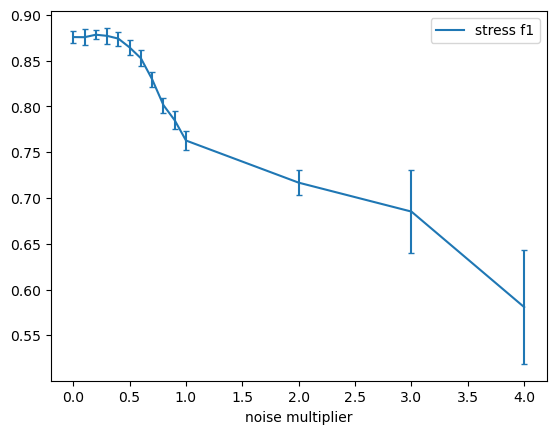

In [64]:
# columns: acc+std rec+std prec+std f1+std unusable
for scenario in SCENARIOS:
    scenario_path = RESULT_PATH + scenario
    result_list = []
    for filename in os.scandir(scenario_path):
        if filename.is_file():
            with open(filename.path) as json_file:
                data = json.load(json_file)
                result_list.append(data)
    if scenario == "1-LOSO_15real":
        df_data = []
        [df_data.append(
            [res["train_config"]["nn_mode"],
             res["privacy_config"]["eps"],
             res["results"]["mean"]["average"]["f1"],
             res["results"]["std"]["average"]["f1"]
            ]) for res in result_list]
        
        df = pd.DataFrame(df_data, columns =["model", 'eps', 'f1', 'std']).fillna(100.0).sort_values("eps").reset_index(drop=True)
        print(df)
        
        sns.catplot(
            x="eps",       # x variable name
            y="f1",       # y variable name
            hue="model",  # group variable name
            data=df,     # dataframe to plot
            kind="bar",
        )
    
    if scenario == "5-LOSO_15real_noised":
        df_data = []
        [df_data.append(
            [res["train_config"]["data_noise_parameter"],
             res["results"]["mean"]["average"]["f1"],
             res["results"]["std"]["average"]["f1"]
            ]) for res in result_list]
        
        df = pd.DataFrame(df_data, columns =['noise multiplier', 'stress f1', 'std']).sort_values("noise multiplier").reset_index(drop=True)
        print(df)
        df.plot(kind='line', x='noise multiplier', y='stress f1', yerr='std', capsize=2)#, xticks=df['noise'])
        #df.plot(kind='line', x='noise multiplier', y='stress f1', yerr='std', capsize=2).get_figure().savefig('test.pdf')
        